## Init setup spark on Google Collab

In [ ]:
## connect to Gdrive 
from google.colab import drive
drive.mount('/content/drive')
datapath = "drive/MyDrive/colab/data/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:



ValueError: ignored

In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
# sparkSession for spark sql
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark.sql import functions as F
from pyspark.sql.types import *

In [ ]:
spark


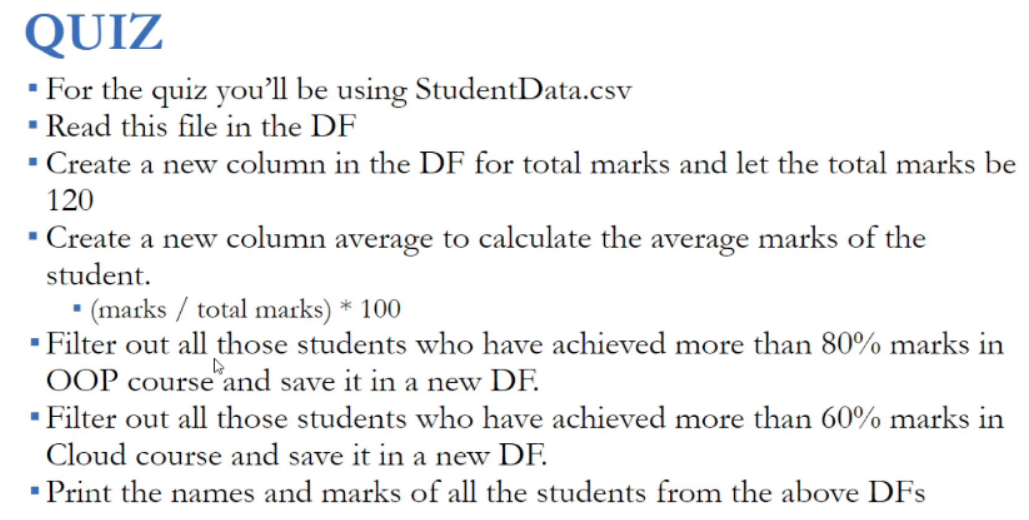

In [ ]:
! head -3 'StudentData.csv'

age,gender,name,course,roll,marks,email
28,Female,Hubert Oliveras,DB,02984,59,Annika Hoffman_Naoma Fritts@OOP.com
29,Female,Toshiko Hillyard,Cloud,12899,62,Margene Moores_Marylee Capasso@DB.com


In [ ]:
df = spark.read.options(header='True', inferSchema='True').csv('StudentData.csv')
df.show(3)
df = df.withColumn("total_marks", F.lit(120))
df = df.withColumn("average", (F.col("marks") / F.col ("total_marks"))*100 )
df_OOP = df.filter((df.course == "OOP") & (df.average > 80))
df_Cloud = df.filter((df.course == "Cloud") & (df.average > 60))

+---+------+----------------+------+-----+-----+--------------------+
|age|gender|            name|course| roll|marks|               email|
+---+------+----------------+------+-----+-----+--------------------+
| 28|Female| Hubert Oliveras|    DB| 2984|   59|Annika Hoffman_Na...|
| 29|Female|Toshiko Hillyard| Cloud|12899|   62|Margene Moores_Ma...|
| 28|  Male|  Celeste Lollis|    PF|21267|   45|Jeannetta Golden_...|
+---+------+----------------+------+-----+-----+--------------------+
only showing top 3 rows



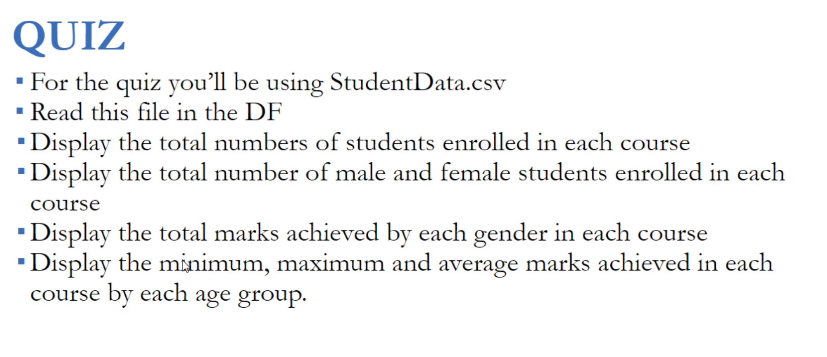

In [ ]:
df.cache()
df.groupby('course').count().show(3)
df.groupby('course','gender').count().orderBy('course','gender').show(5)
df.groupBy('course','gender').sum('marks').orderBy('course','gender').show(5)
df.groupBy('course','age').agg(F.max('marks').alias('min_marks'), F.min('marks'), F.avg('marks')).show(8)

+------+-----+
|course|count|
+------+-----+
|    PF|  166|
|    DB|  157|
|   MVC|  157|
+------+-----+
only showing top 3 rows

+------+------+-----+
|course|gender|count|
+------+------+-----+
| Cloud|Female|  106|
| Cloud|  Male|   86|
|    DB|Female|   75|
|    DB|  Male|   82|
|   DSA|Female|   98|
+------+------+-----+
only showing top 5 rows

+------+------+----------+
|course|gender|sum(marks)|
+------+------+----------+
| Cloud|Female|      6316|
| Cloud|  Male|      5127|
|    DB|Female|      4197|
|    DB|  Male|      5073|
|   DSA|Female|      6124|
+------+------+----------+
only showing top 5 rows

+------+---+---------+----------+------------------+
|course|age|min_marks|min(marks)|        avg(marks)|
+------+---+---------+----------+------------------+
|   MVC| 28|       99|        23| 60.44444444444444|
|   MVC| 29|       99|        22| 61.56470588235294|
| Cloud| 28|       99|        20|             58.08|
|    PF| 29|       99|        20|56.275862068965516|
|    PF|

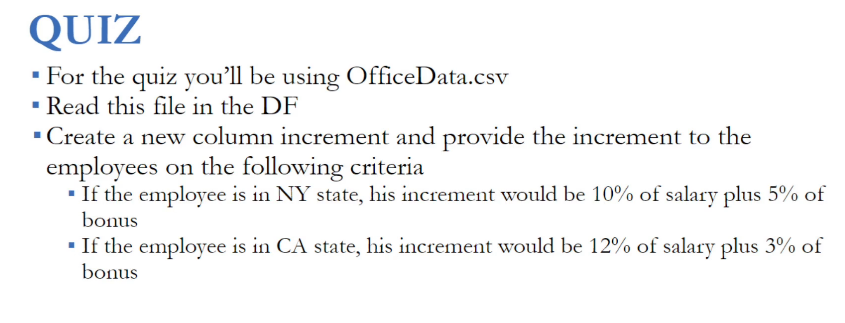

In [ ]:
df = spark.read.csv(
    'OfficeData.csv'
    ,inferSchema = True
    ,sep = ','
    ,header = True
)
df.cache()
df.show(5,False)

+-------------+----------+-----+------+---+-----+
|employee_name|department|state|salary|age|bonus|
+-------------+----------+-----+------+---+-----+
|James        |Sales     |NY   |90000 |34 |10000|
|Michael      |Sales     |NY   |86000 |56 |20000|
|Robert       |Sales     |CA   |81000 |30 |23000|
|Maria        |Finance   |CA   |90000 |24 |23000|
|Raman        |Finance   |CA   |99000 |40 |24000|
+-------------+----------+-----+------+---+-----+
only showing top 5 rows



In [ ]:
# use case when
from pyspark.sql.functions import when
df2 = (
    df.withColumn('increment',F.round(when(F.col('state') == 'NY', F.col('salary') *1.1 + F.col('bonus') *0.05 )
                                .otherwise(F.col('salary') *1.2 + F.col('bonus') *0.03),2)
))
df2.show()

+-------------+----------+-----+------+---+-----+---------+
|employee_name|department|state|salary|age|bonus|increment|
+-------------+----------+-----+------+---+-----+---------+
|        James|     Sales|   NY| 90000| 34|10000|  99500.0|
|      Michael|     Sales|   NY| 86000| 56|20000|  95600.0|
|       Robert|     Sales|   CA| 81000| 30|23000|  97890.0|
|        Maria|   Finance|   CA| 90000| 24|23000| 108690.0|
|        Raman|   Finance|   CA| 99000| 40|24000| 119520.0|
|        Scott|   Finance|   NY| 83000| 36|19000|  92250.0|
|          Jen|   Finance|   NY| 79000| 53|15000|  87650.0|
|         Jeff| Marketing|   CA| 80000| 25|18000|  96540.0|
|        Kumar| Marketing|   NY| 91000| 50|21000| 101150.0|
+-------------+----------+-----+------+---+-----+---------+



In [ ]:
# use UDF
# import pandas as pd
# from pyspark.sql.functions import pandas_udf
def incre(state, salary, bonus):
    if state == 'NY':
        salary = salary *1.1 + bonus *0.05
    else:
        salary = salary *1.2 + bonus *0.03
    return round(salary,2)

from pyspark.sql.functions import udf
increudf = udf(incre,DoubleType()) # shorthand
# incrUDF = udf(lambda x,y,z: incre(x,y,z), DoubleType()) # specify return type
(
    df.withColumn('increment', increudf('state','salary','bonus'))
).show()

+-------------+----------+-----+------+---+-----+---------+
|employee_name|department|state|salary|age|bonus|increment|
+-------------+----------+-----+------+---+-----+---------+
|        James|     Sales|   NY| 90000| 34|10000|  99500.0|
|      Michael|     Sales|   NY| 86000| 56|20000|  95600.0|
|       Robert|     Sales|   CA| 81000| 30|23000|  97890.0|
|        Maria|   Finance|   CA| 90000| 24|23000| 108690.0|
|        Raman|   Finance|   CA| 99000| 40|24000| 119520.0|
|        Scott|   Finance|   NY| 83000| 36|19000|  92250.0|
|          Jen|   Finance|   NY| 79000| 53|15000|  87650.0|
|         Jeff| Marketing|   CA| 80000| 25|18000|  96540.0|
|        Kumar| Marketing|   NY| 91000| 50|21000| 101150.0|
+-------------+----------+-----+------+---+-----+---------+



#Change data capture on AWS Project

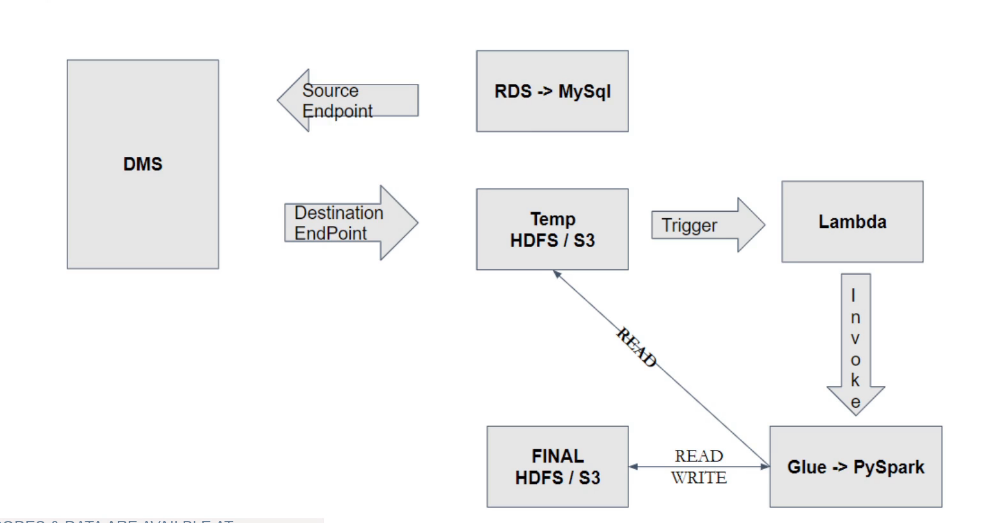

- DMS (redirect endpoint) and capture data change (cdc) into stage
- Glue is managed ETL service (running pyspark)